# SINDy (PDE-find) for discovering the Burgers' equation

This notebook is a control experiment for the PDE-find algorithm in psindy. The results are made to show that pure data-driven nature of PDE-find can't reliably discover the Burgers' equation if data is sparse.

In [174]:
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Disable Warning for sindy
import warnings
def warn(*args, **kwargs): pass
warnings.warn = warn

The data comes from the Burgers' equation defined as:

\begin{align}
\frac{\partial u}{\partial t} = \nu \frac{\partial^2 u}{\partial x^2} - u \frac{\partial u}{\partial x}
\end{align}

where $u(x,t)$ is the velocity field, $\nu$ is the viscosity coefficient, $x \in [-1,1]$ and $t \in [0,1]$. The initial condition is $u(x,0) = -\sin(\pi x)$ and the boundary conditions are $u(-1,t) = u(1,t) = 0$

Load data from the Burgers' equation.

In [175]:
# Load data
data = np.load('data/Burgers.npz')
tsol, xsol, usol = data['t'], data['x'], data['usol']



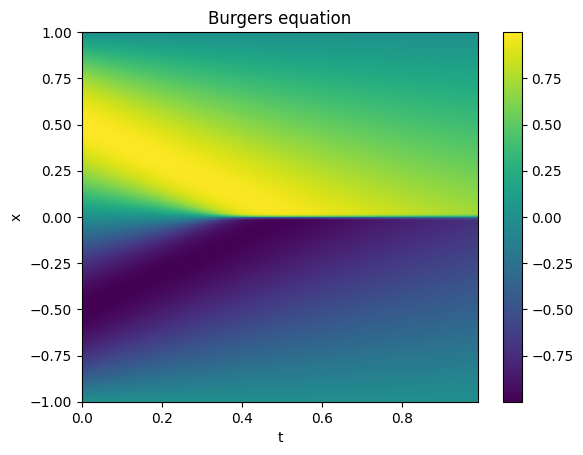

In [176]:
plt.imshow(usol, aspect='auto', cmap='viridis', extent=[tsol.min(), tsol.max(), xsol.min(), xsol.max()])
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')
plt.title('Burgers equation')
plt.show()

In [177]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=xsol,
    include_bias=True,
    is_uniform=True
)

In [199]:
u = usol.reshape(*usol.shape, 1)
dt = (tsol[1] - tsol[0])[0]

optimizer = ps.SR3(threshold=10, max_iter=10000, tol=1e-15, thresholder="l0", normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(u, t=dt)
model.print()

(u)' = -0.413 u + -0.069 uu_1


In [196]:
sol = np.empty((7, 6), dtype=str)

for i, noise in enumerate([0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]):
    print(i)
    for j, sparsity in enumerate([0.02, 0.05, 0.1, 0.2, 0.5, 1.0]):
        ubar = np.mean(abs(usol))
        
        # Extract sparsity % of the columns of usol equispaced in time
        u = usol[:, ::int(1/sparsity)]
        t = tsol[::int(1/sparsity)]
        dt = (t[1] - t[0])[0]

        # Add noise
        u += noise * ubar * np.random.randn(*u.shape)

        print(u.shape)

        cv_folds = TimeSeriesSplit(n_splits=10)
        u = usol.reshape(*usol.shape, 1)
        dt = (tsol[1] - tsol[0])[0]

        scores = []
        for tau in np.logspace(-3, 3, 20):
            optimizer = ps.SR3(threshold=tau, max_iter=10000, tol=1e-15, thresholder="l0", normalize_columns=True)
            model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
            cv_scores = []
            for train_idx, test_idx in cv_folds.split(tsol):
                model.fit(u[:, train_idx], t=dt)
                cv_scores.append(model.score(u[:, test_idx]))
            scores.append(np.mean(cv_scores))

        best_tau = np.logspace(-3, 3, 20)[np.argmax(scores)]

        optimizer = ps.SR3(threshold=best_tau, max_iter=10000, tol=1e-15, thresholder="l0", normalize_columns=True)
        model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
        model.fit(u, t=dt)
        model.print()
        sol[i, j] = model.equations()[0]


0
(256, 2)
(u)' = 0.000
(256, 5)
(u)' = 0.000
(256, 10)
(u)' = 0.000
(256, 20)
(u)' = 0.000
(256, 50)
(u)' = 0.000
(256, 100)
(u)' = 0.000
1
(256, 2)
(u)' = 0.000
(256, 5)


KeyboardInterrupt: 

In [ ]:
cv_folds = TimeSeriesSplit(n_splits=10)
u = usol.reshape(*usol.shape, 1)
dt = (tsol[1] - tsol[0])[0]

scores = []
for tau in np.logspace(-3, 3, 20):
    optimizer = ps.STLSQ(threshold=tau, alpha=1e-5, normalize_columns=True)
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
    cv_scores = []
    for train_idx, test_idx in cv_folds.split(tsol):
        model.fit(u[:, train_idx], t=dt)
        cv_scores.append(model.score(u[:, test_idx]))
    scores.append(np.mean(cv_scores))

best_tau = np.logspace(-3, 3, 20)[np.argmax(scores)]

optimizer = ps.STLSQ(threshold=best_tau, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(u, t=dt)
model.print()


(u)' = 0.004 u_11 + -0.999 uu_1


In [179]:
sol

array([['0', '', '', '', '', ''],
       ['', '', '', '', '', ''],
       ['', '', '', '', '', ''],
       ['', '', '', '', '', ''],
       ['', '', '', '', '', ''],
       ['', '', '', '', '', ''],
       ['', '', '', '', '', '']], dtype='<U1')

In [180]:
u = usol.reshape(*usol.shape, 1)
dt = (tsol[1] - tsol[0])[0]

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=5, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(u, t=dt)
model.print()

print('SR3 model, L0 norm: ')
optimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2,
                   thresholder='l0', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(u, t=dt)
model.print()

print('SR3 model, L1 norm: ')
optimizer = ps.SR3(threshold=20, max_iter=10000, tol=1e-15,
                   thresholder='l1', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(u, t=dt)
model.print()

print('SSR model: ')
optimizer = ps.SSR(normalize_columns=True, kappa=5e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(u, t=dt)
model.print()

print('SSR (metric = model residual) model: ')
optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, kappa=5e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(u, t=dt)
model.print()

print('FROLs model: ')
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-5)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(u, t=dt)
model.print()

STLSQ model: 
(u)' = 0.004 u_11 + -1.000 uu_1
SR3 model, L0 norm: 
(u)' = 0.004 u_11 + -1.000 uu_1
SR3 model, L1 norm: 
(u)' = -0.429 u + -0.075 uu_1
SSR model: 
(u)' = 0.019 u + 0.004 u_11 + -1.004 uu_1
SSR (metric = model residual) model: 
(u)' = 0.019 u + 0.004 u_11 + -1.004 uu_1
FROLs model: 
(u)' = 0.019 u + 0.004 u_11 + -1.004 uu_1
